# f-scLVM

In this notebook we illustrate how f-scLVM can be used to identify biological processes driving variability between cells. 

First, we load some modules and set some directories, we here use the same data as before. 

In [1]:
import sys
sys.path.append('./')
import os
import scipy as SP
import cPickle as pickle
import fscLVM.core as fscLVM
import fscLVM.utils.utils as utils
import h5py
from utils import *
%pylab inline

data_dir = '../../../data/'
out_base = './../results/'



Populating the interactive namespace from numpy and matplotlib


f-scLVM expects a hdf file containing the normalised, log transformed gene expression data as well as a set of annotations. We have put this information together in hdf files. Start off by running the notebook for the T-cell data analysed in the scLVM notebook. Next, use different annotations (REACTOME) instead of MSigDB). Finally, have a look at a data-set of mESC cells staged by cell cycle.

In [17]:
dFile = 'Tcell_sfERCC.hdf5'
#name of annotation
anno = 'MSigDB'

#specify noise model
noise = 'gauss'

#number of hidden (unannotated variables)
nHidden = 1
#indices of known covariates
idx_known = []

idxCol=[0,1]


Next we need to load the relevant data from the hdf5 file. minGenes is the minimum number of genes in a pathway.

In [18]:
data = utils.load_data(dFile, annotation=anno, minGenes=15, nHidden=nHidden, doFast=True, noise=noise)


Next, we initialise the model and iterate.


In [19]:
Y = data['Y']

#use pre-training to determine initial update order 
init_params = {}
init_params['noise'] = noise
init_params['iLatent'] = SP.where(data['terms']=='hidden')[0]

#get initial ordering via pre-training
Ilabel = utils.preTrain(Y, data['terms'], data['pi'],init_params)

#re-order terms
print "Initial order", data['terms'][Ilabel]
terms = data['terms'][Ilabel]
pi = data['pi'][:,Ilabel]


#initialise model
init={'init_data':fscLVM.CGauss(Y),'Pi':pi,'init_factors':init_params}
priors = {'Eps': {'priors':[1E-3,1E-3]}}
FA = fscLVM.CSparseFA(components=pi.shape[1], priors=priors,verbose=True)   
FA.init(**init) 

#iterate
FA.iterate()


Initial order ['hidden' 'MYC_TARGETS_V2' 'G2M_CHECKPOINT' 'E2F_TARGETS' 'Th2' 'HYPOXIA'
 'Cell cycle' 'IL2_STAT5_SIGNALING' 'INTERFERON_ALPHA_RESPONSE'
 'TNFA_SIGNALING_VIA_NFKB' 'UNFOLDED_PROTEIN_RESPONSE' 'P53_PATHWAY'
 'DNA_REPAIR' 'EPITHELIAL_MESENCHYMAL_TRANSITION' 'MTORC1_SIGNALING'
 'XENOBIOTIC_METABOLISM' 'KRAS_SIGNALING_DN' 'COAGULATION'
 'PROTEIN_SECRETION' 'HEME_METABOLISM' 'IL6_JAK_STAT3_SIGNALING'
 'GLYCOLYSIS' 'FATTY_ACID_METABOLISM' 'ALLOGRAFT_REJECTION'
 'APICAL_JUNCTION' 'INFLAMMATORY_RESPONSE' 'UV_RESPONSE_UP'
 'OXIDATIVE_PHOSPHORYLATION' 'ESTROGEN_RESPONSE_EARLY' 'KRAS_SIGNALING_UP'
 'INTERFERON_GAMMA_RESPONSE' 'MITOTIC_SPINDLE' 'ADIPOGENESIS'
 'MYC_TARGETS_V1' 'APOPTOSIS' 'ANDROGEN_RESPONSE' 'COMPLEMENT'
 'PI3K_AKT_MTOR_SIGNALING' 'BILE_ACID_METABOLISM' 'SPERMATOGENESIS'
 'CHOLESTEROL_HOMEOSTASIS' 'ESTROGEN_RESPONSE_LATE' 'UV_RESPONSE_DN'
 'TGF_BETA_SIGNALING' 'REACTIVE_OXIGEN_SPECIES_PATHWAY' 'PEROXISOME'
 'MYOGENESIS']
iteration 0
iteration 100
iteration 200
itera


We then plot results. First, we show the relevance of the terms; then we plot the 2 most important factors, in this case G2M Checkpoint and P53 Pathway. 

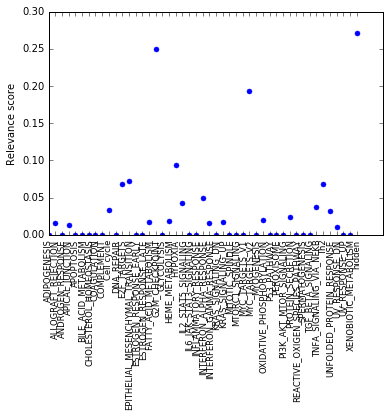

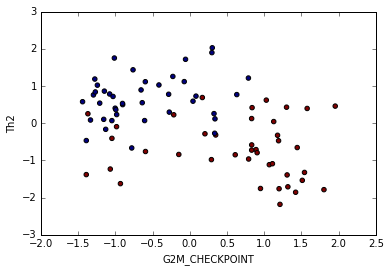

In [29]:
#scatter plot of two most important factors
utils.plotTerms(FA, terms=terms)

dataFile = h5py.File(os.path.join(data_dir, dFile), 'r')
utils.plotFactors(1,6,FA,lab = dataFile['Known'][:][3,:], 
                  terms=terms, isCont=True)


Next, we can look how a Bayesian GPLVM looks like when we regress out confounding facotrs.

In [46]:
import GPy
#Get model residuals
Ycorr = utils.regressOut(Y, idx=[0,2,6],FA=FA)

## Model optimization
Ystd = Ycorr-Ycorr.mean(0)
#Ystd/=Ystd.std(0)
input_dim = 2 # How many latent dimensions to use
kern = GPy.kern.RBF(input_dim,ARD=True) # ARD kernel
m = GPy.models.BayesianGPLVM(Ystd, input_dim=input_dim, kernel=kern, num_inducing=40)
m.optimize('scg', messages=1, max_iters=2000)



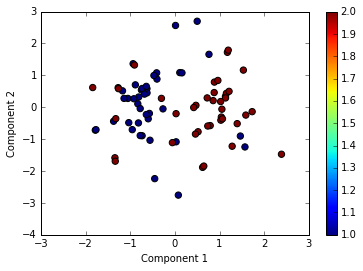

In [47]:
import pylab as PL
PL.scatter(m.X.mean[:,0], m.X.mean[:,1], 40, dataFile['Known'][3,:])
PL.xlabel('Component 1')
PL.ylabel('Component 2')
PL.colorbar()

In [43]:
terms


array(['hidden', 'MYC_TARGETS_V2', 'G2M_CHECKPOINT', 'E2F_TARGETS', 'Th2',
       'HYPOXIA', 'Cell cycle', 'IL2_STAT5_SIGNALING',
       'INTERFERON_ALPHA_RESPONSE', 'TNFA_SIGNALING_VIA_NFKB',
       'UNFOLDED_PROTEIN_RESPONSE', 'P53_PATHWAY', 'DNA_REPAIR',
       'EPITHELIAL_MESENCHYMAL_TRANSITION', 'MTORC1_SIGNALING',
       'XENOBIOTIC_METABOLISM', 'KRAS_SIGNALING_DN', 'COAGULATION',
       'PROTEIN_SECRETION', 'HEME_METABOLISM', 'IL6_JAK_STAT3_SIGNALING',
       'GLYCOLYSIS', 'FATTY_ACID_METABOLISM', 'ALLOGRAFT_REJECTION',
       'APICAL_JUNCTION', 'INFLAMMATORY_RESPONSE', 'UV_RESPONSE_UP',
       'OXIDATIVE_PHOSPHORYLATION', 'ESTROGEN_RESPONSE_EARLY',
       'KRAS_SIGNALING_UP', 'INTERFERON_GAMMA_RESPONSE', 'MITOTIC_SPINDLE',
       'ADIPOGENESIS', 'MYC_TARGETS_V1', 'APOPTOSIS', 'ANDROGEN_RESPONSE',
       'COMPLEMENT', 'PI3K_AKT_MTOR_SIGNALING', 'BILE_ACID_METABOLISM',
       'SPERMATOGENESIS', 'CHOLESTEROL_HOMEOSTASIS',
       'ESTROGEN_RESPONSE_LATE', 'UV_RESPONSE_DN', 'TGF_BET